In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd

import scipy
from scipy.optimize import Bounds
from scipy.optimize import LinearConstraint
from scipy.optimize import NonlinearConstraint
from scipy.optimize import SR1, BFGS
from scipy.optimize import minimize

import confound_mdp
import confound_ope
import confound_env

from core.sepsisSimDiabetes.State import State
from core.sepsisSimDiabetes.Action import Action
from core import generator_confounded_mdp as DGEN
from core import conf_wis as CWIS
from core import loss_minimization as LB
from utils.utils import *

In [95]:
## Below is David's code:
#account for sampling variance:
def fitted_q_update_reparam_sampling(f, pi_e, pihat, P_spsa, gam, data, mdp):
    nStates = P_spsa.shape[0]
    nActions = P_spsa.shape[2]
    #gamma = mdp.gamma
    gamma = 1
    
    eps = 1 / np.sqrt(len(data))
    regression_data = np.array([[s, a, sp, gamma * (pi_e[int(sp),:] @ f[int(sp),:])] for s,a,u,sp,r in data])
    for i in regression_data:
        i[3] += R_sa[int(i[0]), int(i[1])] 

    next_state_sums = np.zeros((nStates, nStates, nActions))
    N_sa = np.zeros((nStates, nActions))
    for s,a,sp,y in regression_data:
        next_state_sums[(int(sp),int(s),int(a))] += y
        N_sa[int(s), int(a)] += 1
        
    f_hat = np.zeros((nStates, nActions))
    for s in range(nStates):
        for a in range(nActions):
            c = next_state_sums[:,s,a] #c
            lower = (pihat[s,a] + (1/gam)*(1-pihat[s,a]))
            upper = (gam + pihat[s,a]*(1-gam))
            bounds = [(lower, upper)]
            if N_sa[s,a] > 0: 
                c /= N_sa[s,a] #c
                f_hat[s,a] = scipy.optimize.linprog(c, A_eq=[P_spsa[:,s,a]], 
                                                 b_eq=[1], bounds=bounds).fun
            else:
                f_hat[s,a] = 0
    return f_hat

def fitted_q_update(f, pi_e, dataset, mdp):
    nStates = mdp.n_states
    nActions = mdp.n_actions
    data = dataset.reshape((dataset.shape[0]*dataset.shape[1],5))
    regression_data = np.array([[x, a, (pi_e[int(xp)] @ f[int(xp),:])] for x,a,u,xp,r in data])
    for i in regression_data:
        i[2] += R_sa[int(i[0]), int(i[1])] 
    Tf_hat = np.zeros((nStates, nActions))
    for x,a,y in regression_data:
        Tf_hat[int(x), int(a)] += y
    idx, count = np.unique(data[:,:2], axis=0, return_counts=True)
    for i,[x,a] in enumerate(idx):
        Tf_hat[int(x),int(a)] /= count[i]
    return Tf_hat

# Lower Bound Experiments

In [2]:
# want an evaluation policy that's better than the behavioral policy
# BUT with unobserved confounding the lower bound on the eval policy is worse than the behavioral policy
#    this is the scenario where the different sensitivity models matter in practice
#    e.g. for policy optimization

In [3]:
envs = []
# each row:
#   [mdp , pi_b, pi_e, horizon, gamma, nStates, nActions, term]

pi_b, P, R, x_dist, u_dist, gamma = confound_env.toy227(0.25, 0.35)
toy = confound_mdp.ConfoundMDP(P, R, x_dist, u_dist, gamma)
horizon = 5
nStates = P.shape[2]
nActions = P.shape[1]
pi_e = np.zeros((nStates, nActions))
for i in range(nStates):
    pi_e[i] = [0.3, 0.7]
    
envs.append([toy, pi_b, pi_e, horizon, gamma, nStates, nActions, -1])

horizon = 4
graph_len = 4
pi_b, P, R, x_dist, u_dist, gamma = confound_env.graph_opetools(horizon=graph_len, slip=0.25, confound_weight=0.23)
R = -1*R
graph = confound_mdp.ConfoundMDP(P, R, x_dist, u_dist, gamma)
nStates = P.shape[2]
nActions = P.shape[1]

pi_e = np.zeros((nStates, nActions))
for i in range(nStates):
    pi_e[i] = [0.3, 0.7]
    
envs.append([graph, pi_b, pi_e, horizon, gamma, nStates, nActions, -1])

horizon = 20
pi_b, P, R, x_dist, u_dist, gamma = confound_env.toymc_opetools(n_left=8, n_right=8, horizon=20, slip=0.15, confound_weight=0.6)
#R = -1*R
toymc = confound_mdp.ConfoundMDP(P, R, x_dist, u_dist, gamma)

nStates = P.shape[2]
nActions = P.shape[1]

pi_e = np.zeros((nStates, nActions))
for i in range(nStates):
    pi_e[i] = [0.15, 0.85]
    
envs.append([toymc, pi_b, pi_e, horizon, gamma, nStates, nActions, -1])

horizon = 8
#, slip = 0.04, confound_weight=0.6
pi_b, P, R, x_dist, u_dist, gamma = confound_env.gridworld_opetools(horizon = horizon, slip = 0.04, confound_weight=0.6)
#R = -1*R
gridworld = confound_mdp.ConfoundMDP(P, R, x_dist, u_dist, gamma)

nStates = P.shape[2]
nActions = P.shape[1]

pi_e = np.zeros((nStates, nActions))
for i in range(nStates):
    pi_e[i] = [0.4, 0.1, 0.4, 0.1]
    
envs.append([gridworld, pi_b, pi_e, horizon, gamma, nStates, nActions, -1])


In [365]:
fqe_envs = []
mb_envs = []

gams = [1.1, 1.5, 2, 3, 4, 6, 8, 10]
nGams = len(gams)

Pbs = [1.1, 1.5, 2, 3, 4, 6, 8, 10]
nPbs = len(Pbs)

#hadds = [0, 5, 10]
hadds = [0]

for mdp , pi_b, pi_e, base_horizon, gamma, nStates, nActions, term in [envs[-1]]:
    
    print("---")
    
    for h in hadds:
        horizon = base_horizon + h
        
        print("running env with horizon " + str(horizon))

        dataset = confound_mdp.collect_sample(int(30000/horizon), mdp, pi_b, horizon)
        data = dataset.reshape((dataset.shape[0]*dataset.shape[1],5))
        Phat = confound_ope.estimate_P(dataset, mdp)
        pihat = confound_ope.estimate_pi(dataset, mdp)
        for a in range(nActions):
            for s in range(nStates):
                if Phat[a,s].sum() == 0:
                    Phat[a,s,term] = 1
                if pihat[s].sum() == 0:
                    pihat[s,:] = 1/nActions
        pi_avg = pi_b[0] * u_dist[0] + pi_b[1] * u_dist[1]
        
        # This is the actual reward_sa
        # P(s,a,s') * R(s,a,s')
        # R(s,a) = \Sum_{s'} P(s,a,s') * R(s,a,s')
        R_sa = (np.average(P, axis=0, weights=u_dist) * R).sum(axis=2).T #np.sum(R, axis=2).T #.reshape(nStates, nActions)
        P_spsa = Phat.transpose((2, 1, 0))
        n = data.shape[0]

         # behavior value
        print("value of pi_b")
        returns = confound_mdp.calc_returns(dataset, gamma, horizon)
        print(returns.mean())

        # no confounding:
        print("value of pi_e with no confounding")
        Q0 = np.zeros((nStates, nActions))
        nom_q = Q0.copy()
        for t in range(horizon):
            nom_q = fitted_q_update(nom_q, pi_e, dataset, mdp)
        print(mdp.get_value(nom_q,pi_e)[1])

        fqe_results = []

        print("now running C-FQE")
        for i,gam in enumerate(gams):
            Q0 = np.zeros((nStates, nActions))
            q_reparam_samp = Q0.copy()
            for t in range(horizon):
                q_reparam_samp = fitted_q_update_reparam_sampling(q_reparam_samp, pi_e, pihat, Pb_spsa, gam, data, mdp)
            fqe_results.append(mdp.get_value(q_reparam_samp,pi_e)[0])

        '''
        print("now running robust mdps...")
        mb_results = np.zeros((nGams, nPbs))

        for i,gam in tqdm(enumerate(gams)):
            for j,P_bound in enumerate(Pbs):
                V0 = np.zeros(nStates)
                fixed_u_v = V0.copy()
                for t in range(horizon):
                    fixed_u_v = confound_ope.fixed_u_gp_s_rect(fixed_u_v, pi_e, 0.50, Phat, pihat, P_bound, gam, mdp)
                mb_results[i,j] = fixed_u_v @ mdp.x_dist

        fqe_envs.append(fqe_results)
        mb_envs.append(mb_results)
        '''

---
running env with horizon 8
value of pi_b
-0.4828986368759634
value of pi_e with no confounding
-0.39282850711107564
now running C-FQE


In [367]:
from numba import njit
#Ptrue_spsa = np.einsum('u,uasp->psa', u_dist, P)
pi_bsa = np.einsum('u,usa->sa', u_dist, pi_b)
@njit
def getPb_spsa(nStates, nActions, u_dist, pi_b, pi_bsa, P):
    prob = np.zeros((nStates, nStates, nActions))
    for sp in range(nStates):
        for s in range(nStates):
            for a in range(nActions):
                for u in range(2):
                    prob[sp, s, a] += u_dist[u] * pi_b[u, s, a] * (1/pi_bsa[s,a]) * P[u, a, s, sp]
    return prob
Pb_spsa = getPb_spsa(nStates, nActions, u_dist, pi_b, pi_bsa, P)



now running C-FQE


# Here's where our work starts

So, here's what I think is going on. For the Gridworld problem, we have a 4x4 gridworld. 
`nStates` is 16, and `nActions` is 4. Of the things we're interested in, 
$$\mathbb{P} \in \mathbb{R}^{U \times A \times  S \times S'}, R \in \mathbb{R}^{A \times S \times S'}, \pi_b \in \mathbb{R}^{U \times S \times  A}, \pi_e \in \mathbb{R}^{S \times A}$$

`P` sums to 128. That, divided by `nStates` and then `nActions`, yields 2. I think then, that `P` gives the conditional transition probabilities given the selection of hidden state $U$.

`Phat` and `pihat` are estimates of the transition probabilities and behavior policy respectively with $U$ marginalized out. `Phat` sums to 64, and is given by the same calculation method of $N(s, a, s')/N(s, a)$ as $\hat{\mathbb{P}}_{\pi_b}(s' | s, a)$, so we can conclude that it is that. Permuting axes to be ordered (s', s, a) gives us `P_spsa`. Additionally, `pihat[a, s]` really gives $\hat{\pi_b}(a | s)$. 

Define `R_sa` to be the array of rewards for each state-action pair. David sets `R[:, i, :]` to be a flattened copy of the grid. That's not really what we're interested in, but we can average the transition probabilities among the distribution of u, take the element-wise product with the `R` array, sum it over the $S'$ axis and take the transpose to obtain `R_sa`.

Actions are indexed WENS

In [13]:
# This is the estimated reward(s, a)
#R_sa = (Phat * confound_ope.estimate_R(dataset, mdp)).sum(axis=2).T
#R_sa
N_sa

array([[1947.,  654.,  655., 1583.],
       [ 914.,  316.,  283.,  748.],
       [ 699.,  250.,  288.,  621.],
       [ 888.,  295.,  325.,  710.],
       [1343.,  478.,  836., 1294.],
       [ 427.,  170.,  284.,  471.],
       [ 154.,   69.,   64.,  180.],
       [ 143.,   71.,   47.,  177.],
       [ 995.,  330.,  661.,  982.],
       [ 340.,  224.,  141.,  307.],
       [ 190.,   68.,   88.,  229.],
       [  78.,   28.,   34.,   96.],
       [1374.,  867.,  538., 1368.],
       [ 631.,  419.,  251.,  613.],
       [ 256.,  183.,  111.,  274.],
       [ 424.,  111.,  114.,  291.]])

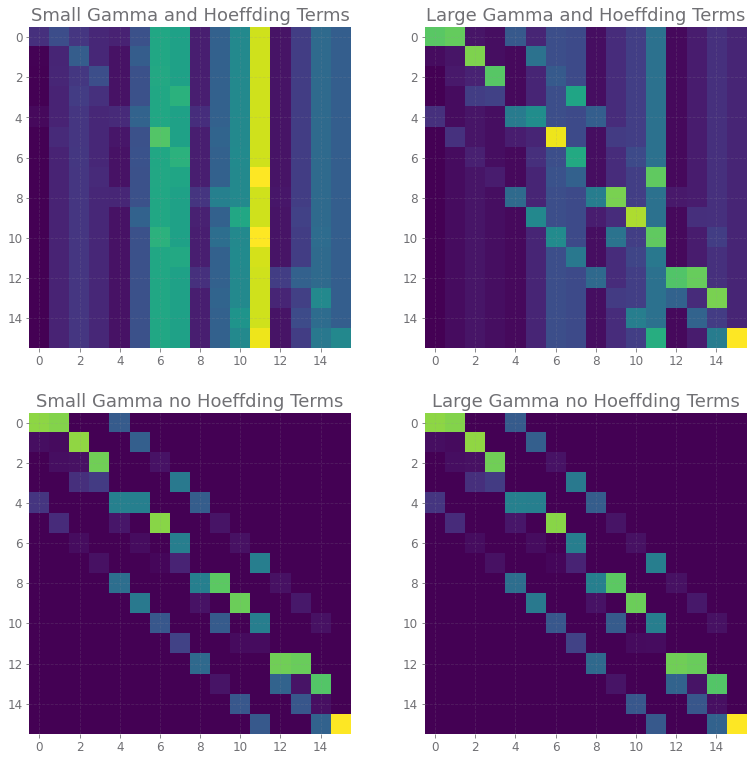

In [215]:
N_sa = np.zeros((nStates, nActions))
for s,a,u,sp,r in data:
    N_sa[int(s),int(a)] += 1

def getBounds(gam, delta, pihat, P_spsa, N_sa, hoeffding=False):
    nStates = N_sa.shape[0]
    nActions = N_sa.shape[1]
    alpha_sa = pihat + (1/gam) * (1-pihat)
    beta_sa = gam + pihat*(1-gam)
    if hoeffding:
        nStates = N_sa.shape[0]
        nActions = N_sa.shape[1]
        G_lb = alpha_sa[np.newaxis,:,:]*(P_spsa - np.sqrt(np.reciprocal(2*N_sa.astype(float)) * np.log((2*n*(nStates**2)*nActions)/delta)))
        G_ub = beta_sa[np.newaxis,:,:]*(P_spsa + np.sqrt(np.reciprocal(2*N_sa.astype(float)) * np.log((2*n*(nStates**2)*nActions)/delta)))
        return G_lb, G_ub
    else:
        return alpha_sa[np.newaxis,:,:]*P_spsa, beta_sa[np.newaxis,:,:]*P_spsa

G_lb, G_ub = getBounds(gams[-1], 0.05, pihat, P_spsa, N_sa, hoeffding=True)
vmin=np.min(G_ub-G_lb)
vmax=np.max(G_ub-G_lb)
action = 0
fig, axs = plt.subplots(2, 2, figsize=(13,13))
G_lb, G_ub = getBounds(gams[0], 0.05, pihat, P_spsa, N_sa, hoeffding=True)
axs[0, 0].imshow((G_ub - G_lb)[:,:,action], vmin=vmin, vmax=vmax)
axs[0, 0].imshow((G_ub - G_lb)[:,:,action])
axs[0, 0].set_title('Small Gamma and Hoeffding Terms')
G_lb, G_ub = getBounds(gams[-1], 0.05, pihat, P_spsa, N_sa, hoeffding=True)
axs[0, 1].imshow((G_ub - G_lb)[:,:,action], vmin=vmin, vmax=vmax)
axs[0, 1].imshow((G_ub - G_lb)[:,:,action])
axs[0, 1].set_title('Large Gamma and Hoeffding Terms')
G_lb, G_ub = getBounds(gams[0], 0.05, pihat, P_spsa, N_sa, hoeffding=False)
smallGam = (G_ub - G_lb)[:,:,action]
axs[1, 0].imshow((G_ub - G_lb)[:,:,action], vmin=vmin, vmax=vmax)
axs[1, 0].imshow((G_ub - G_lb)[:,:,action])
axs[1, 0].set_title('Small Gamma no Hoeffding Terms')
G_lb, G_ub = getBounds(gams[-1], 0.05, pihat, P_spsa, N_sa, hoeffding=False)
largeGam = (G_ub - G_lb)[:,:,action]
axs[1, 1].imshow((G_ub - G_lb)[:,:,action], vmin=vmin, vmax=vmax)
axs[1, 1].imshow((G_ub - G_lb)[:,:,action])
axs[1, 1].set_title('Large Gamma no Hoeffding Terms')

plt.savefig('HoeffdingCompare.png')

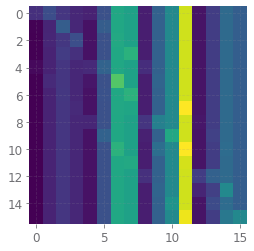

In [178]:
G_lb = alpha_sa[np.newaxis,:,:]*(P_spsa - np.sqrt(np.reciprocal(2*N_sa.astype(float)) * np.log((2*n*(nStates**2)*nActions)/delta)))
G_ub = beta_sa[np.newaxis,:,:]*(P_spsa + np.sqrt(np.reciprocal(2*N_sa.astype(float)) * np.log((2*n*(nStates**2)*nActions)/delta)))
plt.imshow((G_ub - G_lb)[:,:,0])

In [162]:
import gurobipy as gp
from gurobipy import GRB
import time


def softtime(model, where):
    softlimit = 30
    if where == GRB.Callback.MIP:
        runtime = model.cbGet(GRB.Callback.RUNTIME)
        objbst = model.cbGet(GRB.Callback.MIP_OBJBST)
        objbnd = model.cbGet(GRB.Callback.MIP_OBJBND)
        gap = abs((objbst - objbnd) / objbst)

        if runtime > softlimit and gap < 0.5:
            model.terminate()
            
def cb(model, where):
    if where == GRB.Callback.MIPNODE:
        # Get model objective
        obj = model.cbGet(GRB.Callback.MIPNODE_OBJBST)

        # Has objective changed?
        if abs(obj - model._cur_obj) > 1e-8:
            # If so, update incumbent and time
            model._cur_obj = obj
            model._time = time.time()

    # Terminate if objective has not improved in 20s
    if time.time() - model._time > 20:
        model.terminate()

def mbrlLoop(horizon, R_sa, N_sa, P_spsa, pihat, pi_e, so=0):
    objVals = []
    for gam in gams:
        alpha_sa = pihat + (1/gam) * (1-pihat)
        beta_sa = gam + pihat*(1-gam)
        #G_lb = alpha_sa[np.newaxis,:,:]*(P_spsa - 
        #                                 np.sqrt(np.reciprocal(2*N_sa.astype(float)) * 
        #                                np.log((2*n*(nStates**2)*nActions)/delta)))
        #G_ub = beta_sa[np.newaxis,:,:]*(P_spsa + 
        #                                np.sqrt(np.reciprocal(2*N_sa.astype(float)) * 
        #                                np.log((2*n*(nStates**2)*nActions)/delta)))
        G_lb = alpha_sa[np.newaxis,:,:]*(P_spsa)
        G_ub = beta_sa[np.newaxis,:,:]*(P_spsa)
        m = gp.Model('bilinear')
        m.setParam('NonConvex', 2)
        m.setParam('Presolve', 1)
        #m.setParam('Aggregate', 0)
        #m.setParam('NumericFocus', 3)
        #m.setParam('BarHomogeneous', 1)
        #m.setParam('BarCorrectors', 1000)
        #m.setParam('OptimalityTol', 1e-7)
        #m.setParam('FeasibilityTol', 1e-7)
        #m.setParam('BarConvTol', 1e-7)
        #m.setParam('BarQCPConvTol', 1e-7)
        #m.setParam('MIPFocus', 1)
        #m.setParam("OutputFlag", 0)
        #m.setParam('Method', 2)

        # V_2, ... , V_H <=> [0, ..., H-1), H-1 x S sized
        V = m.addVars(horizon, nStates, lb=-5, ub=1, vtype=GRB.CONTINUOUS) 
        Prob_spsa = m.addVars(nStates, nStates, nActions, lb=0, ub=1, vtype=GRB.CONTINUOUS)

        m.update()
        
        # Prob matrix membership constraint
        for sp in range(nStates):
            for s in range(nStates):
                for a in range(nActions):
                    m.addConstr(Prob_spsa[sp, s, a] >= float(G_lb[sp, s, a]))
                    m.addConstr(Prob_spsa[sp, s, a] <= float(G_ub[sp, s, a]))

        # Prob matrix row sum constraint
        for s in range(nStates):
            for a in range(nActions):
                m.addConstr(gp.quicksum(Prob_spsa[sp, s, a] 
                                         for sp in range(nStates)) == 1)

        for s in range(nStates):
            m.addConstr(V[horizon-1, s] == 0)
            
        #for h in range(horizon):
        #    m.addConstr(V[h, 15] == 0)

        # Bellman Backup constraints: H-1 x S ordinary constraints for h = 2,...,H
        for h in range(horizon-1):
            for s in range(nStates):
                m.addConstr(V[h, s] == (gp.quicksum(pi_e[s, a]*R_sa[s, a]
                                                    for a in range(nActions)) + 
                                       gp.quicksum(pi_e[s, a]*Prob_spsa[sp,s,a]*V[h+1,sp] 
                                                    for a in range(nActions) 
                                                    for sp in range(nStates))))
        
        # Directly maximize the quadratic form for V_1(s0). 
        # Substitute so for what we previously called s. 
        # We need V_2(\cdot) in the RHS, so as before subtract 2 and take V[0, sp]
        obj = (gp.quicksum(pi_e[so, a]*R_sa[so, a] 
                            for a in range(nActions)) + 
                gp.quicksum(pi_e[so, a]*Prob_spsa[sp,so,a]*V[0,sp] 
                            for a in range(nActions) 
                            for sp in range(nStates)))
        
        
        m.setObjective(obj, GRB.MINIMIZE)
        m._cur_obj = float('inf')
        m._time = time.time()

        m.optimize(cb)
        #m.optimize()
        objVals.append(m.objVal)
    return objVals

In [375]:
# min \forall h \forall s
def mbrlRelax(horizon, R_sa, N_sa, Pb_spsa, pihat, pi_e):
    nStates = N_sa.shape[0]
    n_actions = N_sa.shape[1]
    Vgams = []
    for gam in gams:
        V = np.zeros((horizon+1, nStates))
        for h in reversed(range(horizon)):
            alpha_sa = pihat + (1/gam) * (1-pihat)
            beta_sa = gam + pihat*(1-gam)
            #G_lb = alpha_sa[np.newaxis,:,:]*(Pb_spsa - 
            #                                 np.sqrt(np.reciprocal(2*N_sa.astype(float)) * 
            #                                np.log((2*n*(nStates**2)*nActions)/delta)))
            #G_ub = beta_sa[np.newaxis,:,:]*(Pb_spsa + 
            #                                np.sqrt(np.reciprocal(2*N_sa.astype(float)) * 
            #                                np.log((2*n*(nStates**2)*nActions)/delta)))
            G_lb = alpha_sa[np.newaxis,:,:]*(Pb_spsa)
            G_ub = beta_sa[np.newaxis,:,:]*(Pb_spsa)
            for so in range(nStates):
                m = gp.Model()
                m.setParam("OutputFlag", 0)
                #m.setParam('Presolve', 0)

                Prob_spsa = m.addVars(nStates, nStates, nActions, lb=0, ub=1, vtype=GRB.CONTINUOUS)

                # Prob matrix membership constraint
                for sp in range(nStates):
                    for s in range(nStates):
                        for a in range(nActions):
                            m.addConstr(Prob_spsa[sp, s, a] >= float(G_lb[sp, s, a]))
                            m.addConstr(Prob_spsa[sp, s, a] <= float(G_ub[sp, s, a]))

                # Prob matrix row sum constraint
                for s in range(nStates):
                    for a in range(nActions):
                        m.addConstr(gp.quicksum(Prob_spsa[sp, s, a] 
                                                 for sp in range(nStates)) == 1)

                # Substitute so for what we previously called s. 
                obj = (gp.quicksum(pi_e[so, a]*R_sa[so, a] 
                                    for a in range(nActions)) + 
                        gp.quicksum(pi_e[so, a]*Prob_spsa[sp,so,a]*V[h+1, sp]
                                    for a in range(nActions) 
                                    for sp in range(nStates)))

                m.setObjective(obj, GRB.MINIMIZE)

                m.optimize()

                V[h, so] = m.objVal
        Vgams.append(V[0,:])
        #for h in reversed(range(horizon)):
        #    print(V[h,:])
    return np.array(Vgams)

In [376]:
relaxResults = mbrlRelax(horizon, R_sa, N_sa, Pb_spsa, pihat, pi_e)

In [392]:
np.sum(np.abs(relaxResults-relaxSamp))/128

0.009487863460977087

In [389]:
np.sum(np.abs(objVals-np.array(objValsSamp)))/128

0.00017235362638250867

In [386]:
objValsSamp = mbrlLoop(horizon, R_sa, N_sa, P_spsa, pihat, pi_e, 0)

Set parameter NonConvex to value 2
Set parameter Presolve to value 1
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 2128 rows, 1152 columns and 3088 nonzeros
Model fingerprint: 0x9674881b
Model has 64 quadratic objective terms
Model has 112 quadratic constraints
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e-01, 4e-01]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e-01, 8e-01]
  Bounds range     [1e+00, 5e+00]
  RHS range        [1e-02, 1e+00]
  QRHS range       [1e-02, 3e-01]
Presolve removed 2068 rows and 815 columns

Continuous model is non-convex -- solving as a MIP

Presolve removed 2056 rows and 840 columns
Presolve time: 0.01s
Presolved: 4464 rows, 1398 columns, 14502 nonzeros
Presolved model has 1085 bilinear constraint(s)
Variable types: 1398 continuous, 0 integer (0 binary)

Root relaxation:

In [363]:
objVals = mbrlLoop(horizon, R_sa, N_sa, Pb_spsa, pihat, pi_e, 0)

Set parameter NonConvex to value 2
Set parameter Presolve to value 1
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 2128 rows, 1152 columns and 3088 nonzeros
Model fingerprint: 0x77db4d78
Model has 64 quadratic objective terms
Model has 112 quadratic constraints
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e-01, 4e-01]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e-01, 8e-01]
  Bounds range     [1e+00, 5e+00]
  RHS range        [4e-02, 1e+00]
  QRHS range       [1e-02, 3e-01]
Presolve removed 2068 rows and 812 columns

Continuous model is non-convex -- solving as a MIP

Presolve removed 2056 rows and 837 columns
Presolve time: 0.01s
Presolved: 4524 rows, 1416 columns, 14702 nonzeros
Presolved model has 1100 bilinear constraint(s)
Variable types: 1416 continuous, 0 integer (0 binary)

Root relaxation:

In [164]:
relaxResults[:,0]

array([-0.183406  , -0.23130999, -0.28212777, -0.35693388, -0.41758376,
       -0.4955549 , -0.53383532, -0.55318632])

In [133]:
V = np.zeros((horizon, nStates))
def recursiveV(h, s):
    if h == horizon-1:
        return 0
    elif V[h,s] != 0:
        return V[h,s]
    else:
        Vhp = np.array([recursiveV(h+1,sp) for sp in range(nStates)])
        V[h+1,:] = Vhp
        return pi_e[s,:].T @ (R_sa[s,:] + P_spsa[:,s,:].T @ Vhp)

recursiveV(0, 14)

-0.258629880558374

In [413]:
fqe_results = []
print("now running C-FQE")
for i,gam in enumerate(gams):
    Q0 = np.zeros((nStates, nActions))
    q_reparam_samp = Q0.copy()
    for t in range(horizon):
        q_reparam_samp = fitted_q_update_reparam_sampling(q_reparam_samp, pi_e, pihat, Pb_spsa, gam, data, mdp)
    fqe_results.append(mdp.get_value(q_reparam_samp,pi_e)[0])

now running C-FQE


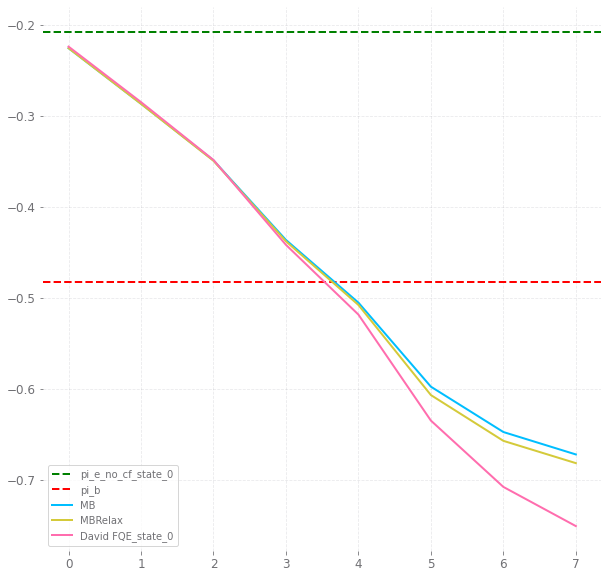

In [423]:
so = 0

returns = confound_mdp.calc_returns(dataset, gamma, horizon)
pi_b_val = returns.mean()

Q0 = np.zeros((nStates, nActions))
nom_q = Q0.copy()
for t in range(horizon):
    nom_q = fitted_q_update(nom_q, pi_e, dataset, mdp)
pi_e_val = mdp.get_value(nom_q,pi_e)[0][so]

fig, ax = plt.subplots(figsize=(10,10))
#change this to R_sa form
ax.axhline(pi_e_val, color='green', linestyle='--', label='pi_e_no_cf_state_' + str(so))
ax.axhline(pi_b_val, color='red', linestyle='--', label='pi_b')

ax.plot(objVals, label='MB')
ax.plot(relaxResults[:,so], label='MBRelax')
ax.plot(np.array(fqe_results)[:,so], label='David FQE_state_'+str(so))
#ax.plot(np.array(cfqe_results)[:,so], label='Our FQE_state_'+str(so))

ax.legend()
plt.savefig("ohdear.jpg")

In [ ]:
from matplotlib import colors

nGams = len(gams)

Pbs = [1.1, 1.5, 2, 3, 4, 6, 8, 10]
nPbs = len(Pbs)

Pbs_ext = np.insert(Pbs,0,0)

deltacol = np.flip(plt.cm.plasma(Pbs_ext / np.amax(Pbs) ), axis=0)

count = 0
envTitles = ["toy", "ope-graph", 'ope-mc', 'ope-gridworld']
for fqe_results, mb_results in zip(fqe_envs,mb_envs):
    fig = plt.figure()
    fig.set_size_inches(7.5, 7)
    plt.plot(gams,fqe_results, color='k')
    for p in range(nPbs):
        plt.plot(gams, mb_results[:,p], color=deltacol[p+1], label="{:.1f}".format(Pbs[p]))
    plt.axhline(pi_e_vals[count], color='green', linestyle='--')
    plt.axhline(pi_b_vals[count], color='red', linestyle='--')
    plt.ylabel("Expected Value")
    plt.xlabel("$\Gamma$")
    plt.xlim([1,10])
    plt.title(envTitles[count])
    plt.grid()
    plt.tight_layout()
    #fig.savefig("cam_ready_lower_bound_plot_%s.pdf" % count)
    count += 1

In [12]:
np.all(G_lb <= P_spsa) and np.all(P_spsa <= G_ub)

True

In [36]:
import gurobipy as gp
from gurobipy import GRB

so = 0

m = gp.Model()
m.setParam('NonConvex', 2)
m.setParam('Presolve', 1)
#m.setParam('NumericFocus', 3)
m.setParam('BarHomogeneous', 1)
#m.setParam('BarCorrectors', 1000)
#m.setParam('OptimalityTol', 1e-9)
#m.setParam('FeasibilityTol', 1e-9)
#m.setParam('BarConvTol', 1e-9)
#m.setParam('BarQCPConvTol', 1e-9)

# V_2, ... , V_H <=> [0, ..., H-1), H-1 x S sized
#V = m.addVars(horizon - 1, nStates, lb=float('-inf'), ub=float('inf')) 
V = m.addVars(horizon, nStates, lb=float('-inf'), ub=float('inf'), vtype=GRB.CONTINUOUS) 
Prob_spsa = m.addVars(nStates, nStates, nActions, lb=0, ub=1, vtype=GRB.CONTINUOUS)


# Prob matrix membership constraint
for sp in range(nStates):
    for s in range(nStates):
        for a in range(nActions):
            m.addConstr(float(G_lb[sp, s, a]) <= Prob_spsa[sp, s, a], 
                        'LB_G_Membership'+str(sp)+str(s)+str(a))
            m.addConstr(Prob_spsa[sp, s, a] <= float(G_ub[sp, s, a]), 
                        'UB_G_Membership'+str(sp)+str(s)+str(a))

# Prob matrix row sum constraint
for s in range(nStates):
    for a in range(nActions):
        m.addConstr(gp.quicksum([Prob_spsa[sp, s, a] 
                                 for sp in range(nStates)]) == 1, 
                    'Row_Sum'+str(s)+str(a))

# V_H+1 = 0 constraint, for h = H to force V_H+1 to be 0
# Also implements S Bellman Backup constraints for V_H
# Unfortunately, it seems like these constraints make the model infeasible
#for s in range(nStates):
    # We want V_H+1 = 0, but we started indexing V_2 at 0
    # So V_H+1 would be located at V[H-1] if it existed
    # But we're setting it to 0, so we can pretend the sum over sp doesn't exist
    # What's on the LHS then? V_H. That corresponds to V[H-2, s].
#    m.addConstr(V[horizon-2, s] == gp.quicksum([pi_e[s, a]*R_sa[s, a]
#                                                for a in range(nActions)]), 
#                                                'H+1'+str(s))

for s in range(nStates):
    m.addConstr(V[horizon-1, s] == 0)

# Bellman Backup constraints: H-2 x S ordinary constraints for h = 2,...,H-1
# Constraints (1 x S of them) for h = H implemented earlier in V_H+1 = 0 constraint
#for h in range(horizon-2):
for h in range(horizon-1):
    for s in range(nStates):
        m.addConstr(V[h, s] == gp.quicksum([pi_e[s, a]*R_sa[s, a]
                                            for a in range(nActions)]) + 
                               gp.quicksum([pi_e[s, a]*Prob_spsa[sp,s,a]*V[h+1,sp] 
                                            for a in range(nActions) 
                                            for sp in range(nStates)]),
                               'Backup'+str(h)+str(s))
        #m.addConstr(V[h, s] == gp.quicksum([pi_e[s, a]*(R_sa[s, a] + Prob_spsa[sp,s,a]*V[h+1,sp]) 
        #                                    for a in range(nActions) 
        #                                    for sp in range(nStates)]), 
        #                                'Backup'+str(h)+str(s))

# Directly maximize the quadratic form for V_1(s0). 
# Substitute so for what we previously called s. 
# We need V_2(\cdot) in the RHS, so as before subtract 2 and take V[0, sp]
#obj = (
obj = m.addVar(lb=float('-inf'), ub=float('inf'), vtype=GRB.CONTINUOUS, name="V0")
m.addConstr(obj == gp.quicksum([pi_e[so, a]*R_sa[so, a] 
                    for a in range(nActions)]) + 
        gp.quicksum([pi_e[so, a]*Prob_spsa[sp,so,a]*V[0,sp] 
                    for a in range(nActions) 
                    for sp in range(nStates)]))

obj.Start = pi_e_val


m.setObjective(obj, GRB.MINIMIZE)
m.optimize()


Set parameter NonConvex to value 2
Set parameter Presolve to value 1
Set parameter BarHomogeneous to value 1
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 2128 rows, 1153 columns and 3088 nonzeros
Model fingerprint: 0x76aa6b05
Model has 113 quadratic constraints
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e-01, 4e-01]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 1e+00]
  QRHS range       [1e-02, 3e-01]
Presolve removed 2068 rows and 812 columns

Continuous model is non-convex -- solving as a MIP


User MIP start did not produce a new incumbent solution
Processed MIP start in 3.05 seconds (4.58 work units)

Presolve removed 2055 rows and 836 columns
Presolve time: 0.00s
Presolved: 4597 rows, 1430 columns, 14015 nonzeros
Presolved model has 1112 bilinear constr

In [93]:
m.objVal

-0.10056963309999338

In [63]:
m.printStats()


Statistics for modelUnnamed:
  Linear constraint matrix    : 2128 Constrs, 1152 Vars, 3088 NZs
  Quadratic constraints       : 112 Constrs, 7280 NZs
  Matrix coefficient range    : [ 1, 1 ]
  Objective coefficient range : [ 0, 0 ]
  Variable bound range        : [ 0, 0 ]
  RHS coefficient range       : [ 0.919679, 1.08835 ]


In [34]:
m

<gurobi.Model MIP instance Unnamed: 2128 constrs, 1152 vars, Parameter changes: FeasibilityTol=0.0001, OptimalityTol=0.0001, GomoryPasses=0, NonConvex=2, NumericFocus=3, Presolve=0>

In [77]:
#model is infeasible
m.computeIIS()


Computing Irreducible Inconsistent Subsystem (IIS)...

           Constraints          |            Bounds           |  Runtime
      Min       Max     Guess   |   Min       Max     Guess   |
--------------------------------------------------------------------------
        0       888         -         0      1149         -           0s

Interrupt request received
        0       888         -         0      1149         -           6s
        0       800         -         0      1147         -          11s
        0       800         -         0      1147         -          15s
        0       800         -         0      1147         -          21s
        0       800         -         0      1147         -          29s
        0       800         -         0      1147         -          36s
        0       800         -         0      1147         -          42s
        0       800         -         0      1147         -          48s
        0       800         -         0      11

In [43]:
#m.feasRelaxS(1, True, False, True)

0.0

In [76]:
m.write('model.ilp')

In [21]:
(horizon - 2) * nStates

96

In [212]:
%load_ext autoreload
%autoreload 2

In [11]:
import pickle

pickle.dump( fqe_envs, open( "fqe_horizon_experiments.p", "wb" ) )
pickle.dump( mb_envs, open( "mb_horizon_experiments.p", "wb" ) )

In [6]:
#fqe_envs = pickle.load( open( "fqe_horizon_experiments.p", "rb" ) )
#mb_envs = pickle.load( open( "mb_horizon_experiments.p", "rb" ) )

In [7]:
# select only base horizon
#fqe_envs = fqe_envs[::3]
#mb_envs = mb_envs[::3]
fqe_envs = feq_envs[0]
mb_envs = mb_envs[0]

In [8]:
pi_e_vals = [0.499015492905087 , 0.7174129322887378, -15.738140536232656, -0.35692764811666317]
pi_b_vals = [0.33965256189333337 , -0.178639828, -18.189038465627075, -0.49942501436258074]

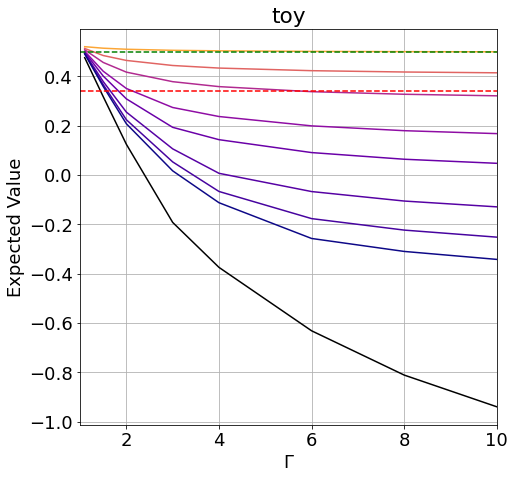

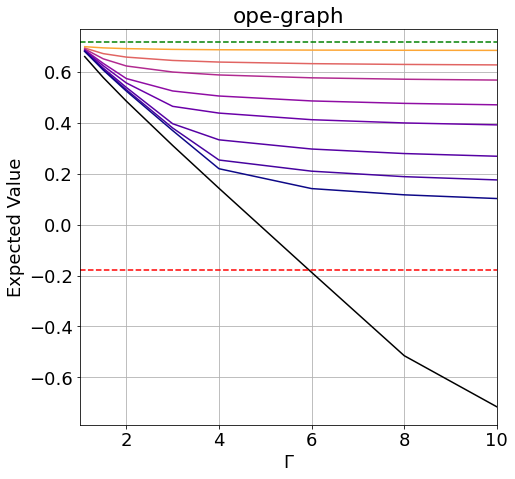

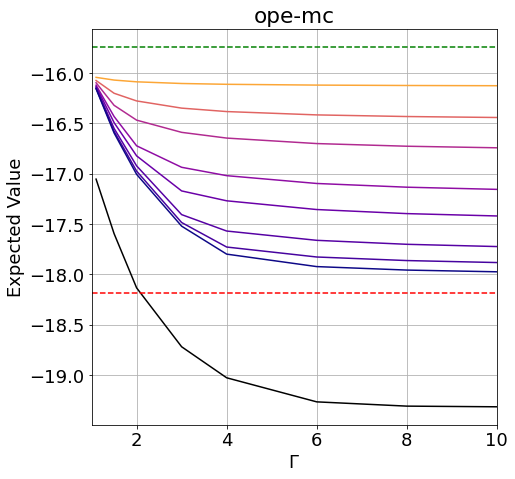

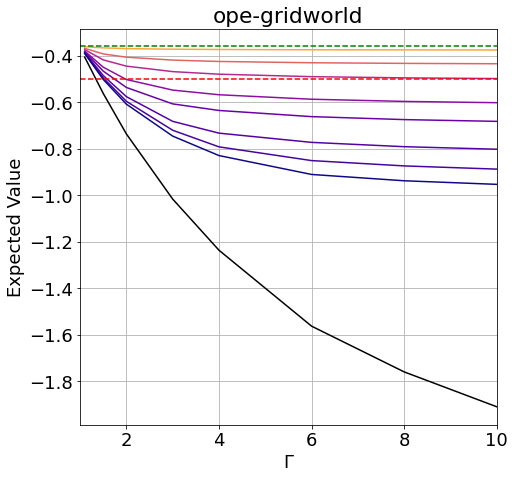

In [10]:
from matplotlib import colors

import matplotlib
matplotlib.rcParams.update({'font.size': 18})

gams = [1.1, 1.5, 2, 3, 4, 6, 8, 10]
nGams = len(gams)

Pbs = [1.1, 1.5, 2, 3, 4, 6, 8, 10]
nPbs = len(Pbs)

Pbs_ext = np.insert(Pbs,0,0)

deltacol = np.flip(plt.cm.plasma(Pbs_ext / np.amax(Pbs) ), axis=0)

count = 0
envTitles = ["toy", "ope-graph", 'ope-mc', 'ope-gridworld']
for fqe_results, mb_results in zip(fqe_envs,mb_envs):
    fig = plt.figure()
    fig.set_size_inches(7.5, 7)
    plt.plot(gams,fqe_results, color='k')
    for p in range(nPbs):
        plt.plot(gams, mb_results[:,p], color=deltacol[p+1], label="{:.1f}".format(Pbs[p]))
    plt.axhline(pi_e_vals[count], color='green', linestyle='--')
    plt.axhline(pi_b_vals[count], color='red', linestyle='--')
    plt.ylabel("Expected Value")
    plt.xlabel("$\Gamma$")
    plt.xlim([1,10])
    plt.title(envTitles[count])
    plt.grid()
    plt.tight_layout()
    #fig.savefig("cam_ready_lower_bound_plot_%s.pdf" % count)
    count += 1